# 导入包

In [2]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle
import function

## 函数定义

In [3]:
def bins_divide(data, relative_data, bins_num):
    bins_interval = np.linspace(np.min(data) * 0.99, max(data) * 1.01, bins_num + 1)
    bins_center_interval = (bins_interval[:-1] + bins_interval[1:]) / 2

    bins_dis = []
    bins_mean = []
    bins_id_data = np.digitize(data, bins_interval) - 1

    for i in range(0, bins_num):
        index_divide = bins_id_data == i
        bins_dis.append(np.std(relative_data[index_divide]))
        bins_mean.append(np.mean(relative_data[index_divide]))

    return bins_center_interval, bins_mean, bins_dis

# Source-Extractor处理和结果

## 文件路径和信息

In [4]:
CONFIG_PATH_1 = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"
CONFIG_PATH_2 = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data_validate/"

band = "C2"
band_short = "r"
band_short_capital = "R"
band_index = 2
day = "240119"
obs_index = "08"
unkonw_index = "01"
exp_time = 300

obs_info = {"01": "20240119020742_20240119021242", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img.fits'
flg_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_flg.fits'
wht_path: str = f'/home/fangwf/MCI_SimData/240119/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_wht.fits'

sext_config_path: str = CONFIG_PATH_1 + "astrom.sex"
sext_para_path: str = CONFIG_PATH_1 + "astrom.param"
sext_filter_path: str = CONFIG_PATH_1 + "gauss_4.0_7x7.conv"
# sext_config_path: str = CONFIG_PATH_2 + "default.sex"
# sext_para_path: str = CONFIG_PATH_1 + "default.param"
# sext_filter_path: str = CONFIG_PATH_2 + "default.conv"
sext_out_path: str = os.path.basename(img_path).replace(".fits", ".acat")
sext_out_path: str = f"{band}_{exp_time}_out.fits"

In [5]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 265.1745710308334, -54.09801556935517


## Source-Extractor结果

### 读取已有或直接处理fits图像

In [6]:
fp_img = img_path
fp_flg = flg_path
fp_wht = wht_path
fp_config_sext = sext_config_path
fp_out_sext = sext_out_path
fp_para_sext = sext_para_path
fp_filter_sext = sext_filter_path

function.work_sext(fp_img,fp_config_sext,fp_out_sext, fp_flg, fp_wht, fp_para_sext,fp_filter_sext)
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out = Table(hdu_list[2].data)

> 
----- SExtractor 2.25.0 started on 2024-05-26 at 21:26:19 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing catalog
> Looking for CSST_MCI_C2_STAR_20240119020742_20240119021242_20200000001_08_L1_V01_img.fits
----- Measuring from: CSST_MCI_C2_STAR_20240119020742_20240119021242_20200000001_08_L1_V01_img.fits [1/1]
      "Unnamed" / no ext. header / 9216x9232 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up backgrou

Filename: C2_300_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [13440A]   
  2  LDAC_OBJECTS    1 BinTableHDU    163   7188R x 39C   [1E, 1E, 1D, 1D, 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1I]   


      Objects: detected 7225     / sextracted 7188            

> Closing files
> 
> All done (in 28.6 s: 322.3 lines/s , 251.0 detections/s)


In [7]:
log_path = "/home/fangwf/MCI_SimData/240119/L0/log_Data"
filename = "star_info_SN_1.fits"

hdu_info = fits.open(os.path.join(log_path, filename))
l0_info = Table(hdu_info[1].data)
filter_x = l0_info[f"posX_{band}"]
filter_y = 9232 - l0_info[f"posY_{band}"]
filter_mag = l0_info["st_magbp"]

sext_out["filter"] = 0
sext_out[f"mag_{band}"] = np.zeros_like(sext_out["filter"], dtype=float)

for l0_x, l0_y, l0_mag in zip(filter_x, filter_y, filter_mag):
    index = ((sext_out["XWIN_IMAGE"] - l0_x) ** 2 + (sext_out["YWIN_IMAGE"] - l0_y) ** 2) < 4
    if np.sum(index) == 1:
        sext_out["filter"][index] = 1
        sext_out[f"mag_{band}"][index] = l0_mag

sext_out_filter = sext_out[sext_out["filter"] == 1]

In [8]:
sext_out_filter

X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,ALPHA_J2000,DELTA_J2000,ALPHAWIN_J2000,DELTAWIN_J2000,X_WORLD,Y_WORLD,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,THETAWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,ELLIPTICITY,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,FLUX_AUTO,FLUXERR_AUTO,BACKGROUND,MAG_AUTO,MAGERR_AUTO,ISOAREAF_IMAGE,FWHM_IMAGE,FLAGS,filter,mag_C2
float32,float32,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,int64,float64
8025.0156,153.6933,8024.822819807794,153.6742120279057,7978,8071,198,106,265.09350613730777,-54.15995786239541,265.09351071559155,-54.15995813050692,265.09350613730777,-54.15995786239541,20.422526744920493,5.17238629824876,0.002690613094454885,0.0009233202081042467,4.520774,2.2710161,0.051931247,0.030283308,1.787768,3.394984,0.049070995,0.19375075,0.5590515,6.278929e-05,3.1540174e-05,7.2128245e-07,4.2057337e-07,40782.168,240.99194,0.19067566,-11.5261755,0.0064174435,6262,45.793694,0,1,16.616312
7711.7646,144.99529,7711.6805170058105,145.02700733875474,7674,7747,181,107,265.1009363641899,-54.16008342923988,265.10093835883407,-54.16008298984066,265.1009363641899,-54.16008342923988,6.5035504793425485,2.214668566416375,0.0012057138191171788,0.0005277169499164989,2.5530164,1.4833497,0.03478197,0.022883298,3.304093,4.4180303,0.15442388,0.45347798,0.26584738,3.545922e-05,2.0600844e-05,4.8309323e-07,3.1780664e-07,16248.438,114.79845,0.18103604,-10.527029,0.007672806,3581,29.840328,0,1,17.498306
861.8896,88.6691,861.7116875729743,88.67955038882697,833,893,116,63,265.2634203888382,-54.16085549666801,265.26342460854477,-54.16085534840806,265.2634203888382,-54.16085549666801,3.410310136113078,1.4301361800700942,0.0009841801891101597,0.0005252866584762508,1.8473858,1.1948273,0.03138826,0.022896374,2.0433743,2.7260501,0.29352963,0.6999523,0.18178028,2.5657764e-05,1.6595313e-05,4.3594136e-07,3.18013e-07,9182.514,81.23316,0.1802571,-9.907404,0.009607306,2163,24.345905,0,1,17.673443
2451.4985,92.17106,2451.471503990822,92.31092085671624,2435,2472,108,74,265.2257133542686,-54.16082872338342,265.2257139943269,-54.16082678055115,265.2257133542686,-54.16082872338342,0.7596818459169395,0.5631645162180103,0.0008357689852079586,0.0006564317442967272,0.87227225,0.7496583,0.028914088,0.025615938,4.412192,2.1600525,1.3170569,1.7766464,0.06511849,1.2114794e-05,1.0412008e-05,4.0158304e-07,3.5577776e-07,3027.9832,45.67365,0.17801379,-8.702884,0.016381063,948,3.0904973,2,1,19.545483
1420.1295,73.138504,1419.9975583732257,73.17296834593589,1392,1449,103,50,265.25017883104823,-54.161080219366404,265.2501819590902,-54.16107973874376,265.25017883104823,-54.161080219366404,3.151240998743552,1.3103256071463392,0.0009880672562040875,0.000506413353508548,1.7763131,1.1429255,0.031460244,0.022466278,2.6815162,3.3737786,0.31791016,0.7645516,0.14837015,2.4670624e-05,1.58745e-05,4.369406e-07,3.1204053e-07,8551.962,78.78749,0.17926866,-9.830164,0.010005098,2005,19.42138,0,1,18.122917
4606.3677,81.62814,4606.2795623908305,81.75029861954579,4591,4622,97,67,265.17459788707964,-54.160985986438185,265.17459998083746,-54.16098428985244,265.17459788707964,-54.160985986438185,0.4590633008583452,0.44712706899073734,0.000979711162141795,0.0009395873695767676,0.684507,0.661544,0.031497527,0.030450031,33.641827,25.902548,2.1805077,2.2387173,0.015235841,9.507035e-06,9.188102e-06,4.3746533e-07,4.2291663e-07,1688.9985,33.498695,0.17433333,-8.069073,0.021539144,720,1.7162333,0,1,21.244184
5509.962,65.37092,5509.868251324645,65.49520774587059,5496,5525,79,52,265.1531636173458,-54.16120988268733,265.153165835239,-54.1612081568896,265.1531636173458,-54.16120988268733,0.40344098417781715,0.43372104451312227,0.0012

# Gaia参考星获取

## 读取已有或直接网络下载

In [9]:
ref_filter = pd.read_csv(f"validate_test/result/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L1_V01_img_out.txt", delimiter=" ")
ref_filter

,xi(deg),eta(deg),x(micron),y(micron),ra_gaia(deg),dec_gaia(deg),ra_J2025(deg),dec_J2025(deg),Gmag(mag),BPmag(mag),...,XMAX_IMAGE,YMAX_IMAGE,X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,actual_ra,actual_dec
0,0.047238,0.056364,23084.792921,27544.862153,265.255038,-54.041565,265.255016,-54.041627,13.011389,13.391389,...,8421.0,626.0,8033.349121,499.954956,8033.148053,499.544165,0.007869,0.000451,265.255028,-54.041638
1,0.032277,0.049206,15773.490441,24046.446893,265.229562,-54.048764,265.229547,-54.048800,13.119484,13.412379,...,7284.0,1121.0,6945.426758,1033.696777,6945.397834,1033.656260,0.006505,0.000270,265.229561,-54.048799
2,-0.041794,-0.034415,-20424.416875,-16818.409903,265.103232,-54.132397,265.103242,-54.132408,13.612459,14.339624,...,1872.0,7160.0,1608.256348,7069.403809,1608.482585,7069.369032,0.006973,0.000311,265.103257,-54.132408
3,-0.026165,0.011864,-12786.855539,5797.920515,265.129981,-54.086130,265.129964,-54.086144,13.668643,14.365914,...,2951.0,3836.0,2721.863525,3756.265869,2721.836198,3756.225288,0.006515,0.000304,265.129974,-54.086142
4,-0.025939,-0.014460,-12676.005668,-7066.349258,265.130345,-54.112361,265.130323,-54.112466,13.680549,14.013255,...,2939.0,5719.0,2744.633057,5650.070801,2744.589236,5650.058670,0.005163,0.000349,265.130345,-54.112465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,0.019386,0.025485,9473.726856,12454.558735,265.207648,-54.072534,265.207609,-54.072527,20.872420,21.695398,...,6019.0,2782.0,6007.354004,2772.223633,6007.213626,2772.381485,0.002652,0.003122,265.207605,-54.072528
1411,-0.040488,-0.046779,-19786.392995,-22860.717767,265.105464,-54.144751,265.105450,-54.144772,20.874277,21.482796,...,1715.0,7956.0,1704.551270,7948.231445,1704.405383,7948.364750,0.006154,0.005541,265.105445,-54.144775
1412,-0.031767,0.004887,-15524.078902,2388.283938,265.120409,-54.093108,265.120407,-54.093117,20.875180,21.571766,...,2330.0,4268.0,2319.245605,4258.230957,2319.152904,4258.367608,0.003383,0.003847,265.120405,-54.093118
1413,0.012975,-0.001194,6340.652525,-583.638450,265.196733,-54.099193,265.196697,-54.099208,20.875967,21.368162,...,5554.0,4713.0,5542.488281,4702.024414,5542.333778,4702.143499,0.003071,0.002736,265.196695,-54.099209


# 三角形匹配

## Gaia参考星匹配库

In [10]:
refcat_ra_now = np.array(ref_filter["ra_J2025(deg)"])
refcat_dec_now = np.array(ref_filter["dec_J2025(deg)"])

refcat_ra_now_filter = refcat_ra_now[ref_filter["Gmag(mag)"] < np.percentile(ref_filter["Gmag(mag)"], 10)]
refcat_dec_now_filter = refcat_dec_now[ref_filter["Gmag(mag)"] < np.percentile(ref_filter["Gmag(mag)"], 10)]

ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, function.pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,265.229547,265.255016,265.103242,-54.048800,-54.041627,-54.132408,0.127147,0.111705,0.016585
1,265.229547,265.255016,265.129964,-54.048800,-54.041627,-54.086144,0.085837,0.069351,0.016585
2,265.229547,265.255016,265.130323,-54.048800,-54.041627,-54.112466,0.101834,0.086266,0.016585
3,265.229547,265.220460,265.255016,-54.048800,-54.054388,-54.041627,0.023968,0.016585,0.007726
4,265.229547,265.255016,265.218086,-54.048800,-54.041627,-54.077324,0.041763,0.029307,0.016585
...,...,...,...,...,...,...,...,...,...
467175,265.240290,265.199324,265.075205,-54.106674,-54.157236,-54.065453,0.117125,0.105243,0.055970
467176,265.199324,265.152080,265.280123,-54.157236,-54.156736,-54.104526,0.091404,0.070850,0.027669
467177,265.240290,265.280123,265.152080,-54.106674,-54.104526,-54.156736,0.091404,0.071955,0.023452
467178,265.199324,265.152080,265.240290,-54.157236,-54.156736,-54.106674,0.071955,0.055970,0.027669


## 图像星匹配库

In [11]:
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = function.ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, function.pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])

sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,265.229454,265.254459,265.129733,-54.047993,-54.055717,-54.101923,0.086541,0.079573,0.016588,1.0,0.0,2.0,1.0,0.0,2.0
1,265.229454,265.254459,265.093324,-54.047993,-54.055717,-54.155167,0.137169,0.133632,0.016588,1.0,0.0,3.0,1.0,0.0,3.0
2,265.254459,265.229454,265.263011,-54.055717,-54.047993,-54.141780,0.095830,0.086209,0.016588,0.0,1.0,4.0,0.0,1.0,4.0
3,265.229454,265.254459,265.119139,-54.047993,-54.055717,-54.147749,0.121514,0.118895,0.016588,1.0,0.0,5.0,1.0,0.0,5.0
4,265.254459,265.245550,265.229454,-54.055717,-54.063914,-54.047993,0.018513,0.016588,0.009723,0.0,6.0,1.0,0.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,265.278074,265.159170,265.071392,-54.069911,-54.155128,-54.041356,0.124874,0.124637,0.110091,35.0,39.0,38.0,35.0,39.0,38.0
9876,265.110373,265.071392,265.272389,-54.121540,-54.041356,-54.102690,0.132933,0.096827,0.083381,36.0,38.0,37.0,36.0,38.0,37.0
9877,265.159170,265.110373,265.272389,-54.155128,-54.121540,-54.102690,0.096827,0.084564,0.044106,39.0,36.0,37.0,39.0,36.0,37.0
9878,265.110373,265.159170,265.071392,-54.121540,-54.155128,-54.041356,0.124874,0.083381,0.044106,36.0,39.0,38.0,36.0,39.0,38.0


## 三角形弧长匹配

In [12]:
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])

match_lib

## 结果

In [ ]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()

# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 40
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)

# 底片模型计算

## 初步底片模型

### 计算初步底片模型

In [ ]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = function.cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe
Y_eta = match_res_eta_gaia_uniqe
# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 3
A_CD_PRE = function.cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof_xy)
print(A_CD_PRE)

NameError: name 'function' is not defined

### 应用初步底片模型

In [ ]:
# 应用
match_xieta = function.use_plate_model(match_x - x_ref, match_y - y_ref, A_CD_PRE, cof_xy)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[  0.88896447 -10.21984315   6.79648911   4.3897265   -5.86441431
   7.91492414   2.16284534  -0.27380031  -1.92012969 -12.31830315
 -20.0618716   -5.86232538  30.7118089    0.76757524  -0.69658752
  -1.47232365  12.98178031  -3.70405223   2.92368436  -7.1441488 ]
[-1.27564094  1.15868845 -0.13993074  2.48919638 -1.90780624  1.60073102
  0.376121   -0.4895419  -0.70889882 -2.65381529  6.90834925 -1.91403276
 -3.4983542  -0.09034378 -0.20809134  0.46653842  1.20388538 -1.83908377
 -0.5098621   1.03188953]


### 画图

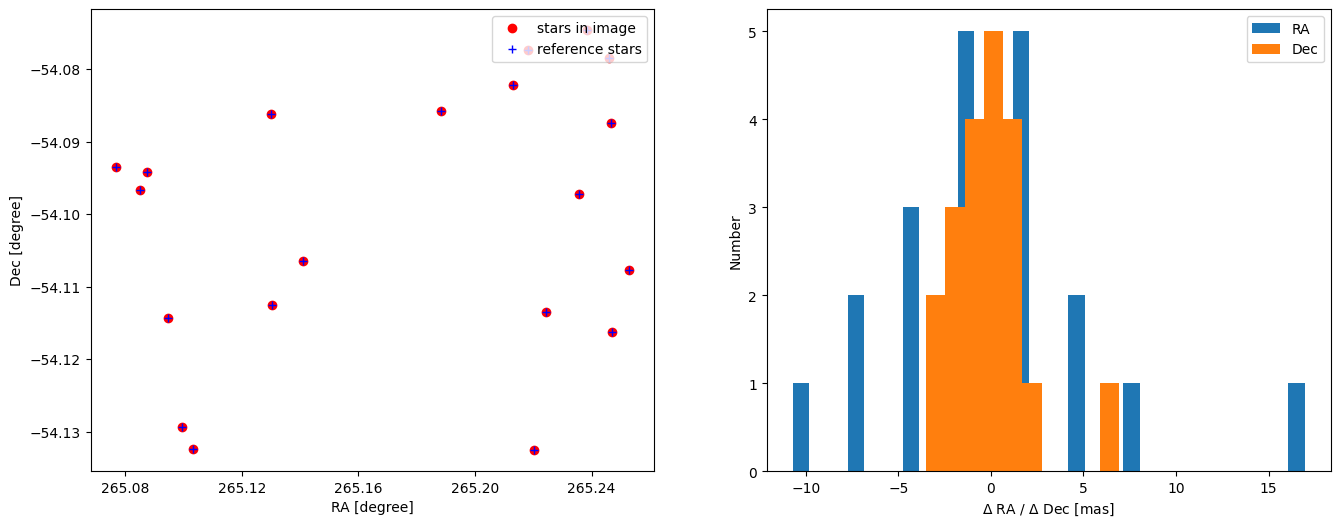

In [ ]:
# fig, axes = plt.subplots(1, 1, figsize= (6, 6))
# from matplotlib.ticker import MaxNLocator

# # axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
# axes.set_ylabel("Dec [degree]")
# axes.set_xlabel("RA [degree]")
# axes.xaxis.set_major_locator(MaxNLocator(5))
# axes.legend(loc=1)
fig, axes = plt.subplots(1, 2, figsize= (16, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes[0].plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes[0].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes[0].set_ylabel("Dec [degree]")
axes[0].set_xlabel("RA [degree]")
axes[0].xaxis.set_major_locator(MaxNLocator(5))
axes[0].legend(loc=1)


axes[1].hist((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000 * np.mean(np.cos(match_res_dec_gaia_uniqe / 180 * np.pi)), label="RA", bins=10, rwidth=0.3)
axes[1].hist((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000, label="Dec", bins=10, rwidth=1)
axes[1].set_xlabel(r"$\Delta$ RA / $\Delta$ Dec [mas]")
axes[1].set_ylabel("Number")
axes[1].legend(loc=1)

## 更新底片模型

### 全体星应用初步模型

In [ ]:
sext_flags = sext_out_filter[:]["FLAGS"]
sext_out_x = sext_out_filter[:]["X_IMAGE"][sext_flags == 0]
sext_out_y = sext_out_filter[:]["Y_IMAGE"][sext_flags == 0]

sext_out_xieta = function.use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD_PRE, cof_xy)
sext_out_radec = function.ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

### 全体星天球位置匹配

In [ ]:
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now, "magrp": ref_filter["RPmag(mag)"], "magg": ref_filter["Gmag(mag)"], "magbp": ref_filter["BPmag(mag)"]})
side_threshold = 0.00001

match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all.iloc[:, 0:2] - temp_lib) < side_threshold, axis=1) == 2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), refcat_lib_all.iloc[np.where(index == True)[0][0]])))

match_res_all = np.array(match_res_all)

### 计算更新的底片模型

In [ ]:
match_res_xi_gaia_all, match_res_eta_gaia_all = function.cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all
Y_eta = match_res_eta_gaia_all

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)

for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag = match_res_all[:, band_index + 4]


print("the matched stars", len(match_x))

# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 3
cof_mag = 3

A_CD = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)
print(A_CD)

the matched stars 700
[[ 2.94845972e-06  2.42445651e-07 -9.04216074e-11  2.59442758e-14
   3.55932489e-13  1.14109802e-14 -1.33512314e-17 -2.45399284e-20
  -1.74061985e-17 -2.36648549e-19  1.38942519e-22  9.15742794e-23
  -2.48517644e-22  1.70995107e-22  9.05045193e-23 -6.38244482e-27
  -4.10649950e-27  2.15781705e-26  6.18896540e-28  6.92156158e-26
  -2.31901504e-26 -5.03472925e-30  5.31623354e-30  1.70824827e-30
  -8.71815949e-30  1.02575069e-29 -6.26564853e-30  1.43141818e-30
  -6.10169162e-07  3.67585160e-08 -7.15439153e-10]
 [ 6.55204600e-07  1.19067710e-10 -2.42592707e-07 -2.32745188e-13
  -2.01199451e-14 -6.48219572e-13 -5.05035816e-20  1.65740199e-17
   2.16374280e-19  1.93429007e-17 -1.52212722e-23 -5.38934675e-23
  -3.42594801e-22  2.93120846e-23  1.63451386e-22  2.78834549e-27
  -8.51663903e-27  1.52329112e-27 -5.91137866e-26 -9.90227501e-26
  -1.53714025e-26 -1.10251033e-30 -2.07472561e-30  7.63544705e-30
   6.99052295e-30  1.80877419e-29  2.03467783e-29 -5.66361563e-30
  -

### 再应用更新的底片模型

In [ ]:
match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD, cof_xy, cof_mag)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

print(np.std(dis_ra), np.std(dis_dec), cof_xy, cof_mag)

3.289706651040523 1.7373012103285577 6 3


In [ ]:
# 保存
cof_mag_orders = 4
cof_xy = 3
for cof_mag in np.arange(1, cof_mag_orders + 1):

    A_CD_LOOP = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)

    match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD_LOOP, cof_xy, cof_mag)
    match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
    gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
    gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)

    # 残差
    dis_xi = (match_xieta[0] - gaia_xieta[0])
    dis_eta = (match_xieta[1] - gaia_xieta[1])
    dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
    dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

    match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

    with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}_{cof_xy}_{cof_mag}.pkl', 'wb') as f:
        pickle.dump(match_res_pickle, f)

In [ ]:
# match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

# with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}.pkl', 'wb') as f:
#     pickle.dump(match_res_pickle, f)

# 残差分析

## 残差图

### 网格化

In [ ]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = function.match_box_id(match_x, match_y, bins_x, bins_y)

### 星等残差图

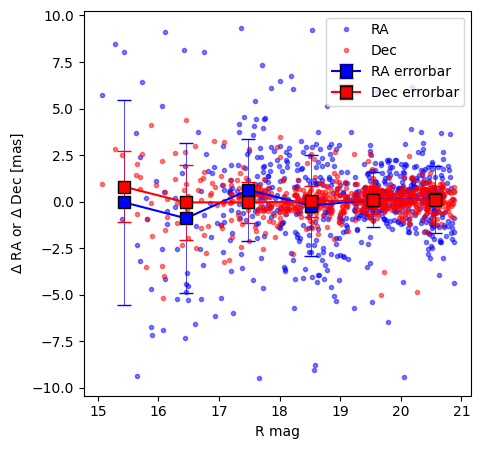

In [ ]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        index_box = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag[index_box]
        match_x_box = match_x[index_box]
        match_y_box = match_y[index_box]
        dis_ra_box = dis_ra[index_box]
        dis_dec_box = dis_dec[index_box]

        dis_ra_box, dis_dec_box, match_mag_box, filter = function.sigma_filter_2(dis_ra_box, dis_dec_box, match_mag_box, 3)
        index_mag = (match_mag_box < 29) & (match_mag_box > 15)

        dis_ra_box = dis_ra_box[index_mag]
        dis_dec_box = dis_dec_box[index_mag]
        match_mag_box = match_mag_box[index_mag]

        bin_centers_mag_box, bins_mean_dis_ra_box, bins_std_dis_ra_box = bins_divide(match_mag_box, dis_ra_box, 6)
        bin_centers_mag_box, bins_mean_dis_dec_box, bins_std_dis_dec_box = bins_divide(match_mag_box, dis_dec_box, 6)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_box, dis_ra_box, '.', c='blue', label="RA", alpha = 0.5)
        axe.plot(match_mag_box, dis_dec_box, '.', c='red', label="Dec", alpha = 0.5)
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_ra_box, yerr=bins_std_dis_ra_box, ecolor='blue',elinewidth=0.5,marker='s',mfc='blue',mec='k',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="blue",label="RA errorbar")
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_dec_box, yerr=bins_std_dis_dec_box, ecolor='red',elinewidth=0.5,marker='s',mfc='red',mec='k',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="red",label="Dec errorbar")

        axe.set_xlabel(f"{band_short_capital} mag")
        axe.set_ylabel(r"$\Delta$ RA or $\Delta$ Dec [mas]")

        axe.legend()

### 位置残差图

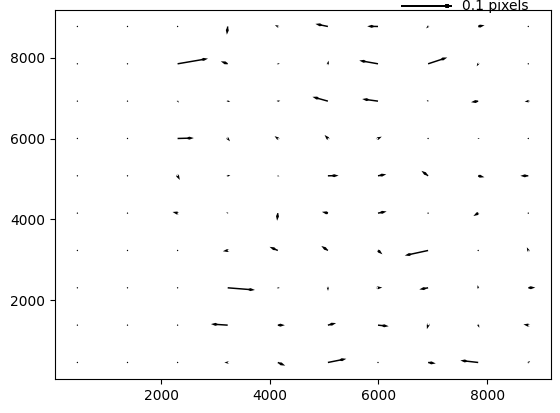

In [ ]:
bins_num = 10
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
dis_res_xy = [np.vstack((match_x[filter][index_mag], match_y[filter][index_mag], dis_ra[filter][index_mag], dis_dec[filter][index_mag]))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

fig, axes = plt.subplots(1, 1)
quiver_scale = 9216
quiver_show_scale = 0.1
quiver = axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten() / 50, distort_mean_values_y.flatten() / 50, scale=1 / quiver_scale, angles = 'xy', scale_units="xy", headwidth=2, headlength=3, width=0.003)
axes.quiverkey(quiver, 0.8, 1.01, quiver_show_scale, f"{quiver_show_scale} pixels",labelpos='E', coordinates='axes')